# 1. Configurations

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import json
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import GradCAM
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Define Model and Classifier Wrapper

In [3]:
DROPOUT_RATE = 0.5

class customModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        # 1) SwinV2 backbone without head/pooling
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0, # out_features, strip of model head/classifier
            global_pool="" # no pooling
        )
        in_features = self.model.num_features
        # 2) pooling + dropout + classifier head
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fully_connect = nn.Linear(in_features, num_classes) # head/classifier

    def forward(self, imgs):
        # 1) get feature map
        fmap = self.model.forward_features(imgs)  # could be [B, H, W, C] or [B, C, H, W]
        if fmap.dim() == 4 and fmap.shape[-1] == self.model.num_features:
            fmap = fmap.permute(0, 3, 1, 2) # Permute to [B, C, H', W']
        # 2) pool + head
        pooled = self.global_avg_pool(fmap).view(fmap.size(0), -1)
        features = self.dropout(pooled)
        output = self.fully_connect(features) # Pass through a linear fc layer to get one score per class for each example in the batch: [B, num_classes]
        return output

In [4]:
class Classifier:
    def __init__(self, model, transform, label_columns, thresholds, device):
        self.model = model
        self.transform = transform
        self.label_columns = label_columns 
        self.thresholds = thresholds
        self.device = device

    def predict_probability(self, img):
        tensor = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(tensor)
            return torch.sigmoid(logits).cpu().numpy()[0]

    def predict_binary(self, img):
        probabilities = self.predict_probability(img)
        return (probabilities >= self.thresholds).astype(int)

    @staticmethod
    def load(best_model_filename, classifier_config_filename):
        config = json.load(open(classifier_config_filename))
        # Extract config
        model_name = config["model_name"]
        mean = config["mean"]
        std = config["std"]
        img_width = config["img_width"]
        label_columns = config["label_columns"]
        thresholds = np.array(config["thresholds"], dtype=float)
        # rebuild evaluation transforms
        transform = transforms.Compose([
            transforms.Resize((img_width, img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        # rebuild and load model
        model = customModel(model_name=model_name, num_classes=len(label_columns), pretrained=False)
        state = torch.load(best_model_filename, map_location=device)
        model.load_state_dict(state)
        model.to(device).eval()
        classifier = Classifier(
            model=model,
            transform=transform,
            label_columns=label_columns,
            thresholds=thresholds,
            device=device
        )
        # return the classifier plus the raw metadata
        return classifier, mean, std, img_width


## 3. Using Classifier

Partitions loaded from .csv files.


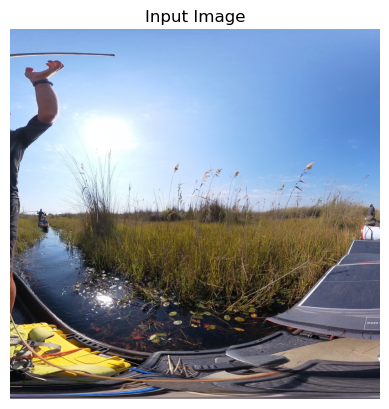

Found in partition: train
Labels:         ['Open Water', 'Floating Vegetation', 'Reedlands & Permanent Swamps', 'Tall Seasonal Sedge Wetlands', 'Short Seasonal Grass Floodplains', 'Riparian Forest', 'Woodlands', 'Bare Ground / Dry Grass', 'Shrubland', '[Lvl 2] Water Lily', '[Lvl 2] Rafts', '[Lvl 2] Salvinia / Other Fern', '[Lvl 2] Papyrus', '[Lvl 2] Phragmites / Miscanthus']
Thresholds:     [0.226, 0.563, 0.504, 0.009, 0.841, 0.060, 0.033, 0.808, 0.857, 0.152, 0.089, 0.773, 0.121, 0.067]
Probabilities:  [0.014, 0.001, 0.007, 0.996, 0.004, 0.000, 0.001, 0.001, 0.002, 0.891, 0.421, 0.011, 0.033, 0.940]
Predictions:    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
GroundTruth:    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Predicted Class Names:    ['Tall Seasonal Sedge Wetlands', '[Lvl 2] Water Lily', '[Lvl 2] Rafts', '[Lvl 2] Phragmites / Miscanthus']
Ground Truth Class Names: ['Tall Seasonal Sedge Wetlands', '[Lvl 2] Water Lily', '[Lvl 2] Rafts', '[Lvl 2] Phragmites / Miscanthus']


In [ ]:
# Reloads model, thresholds, labels, and wraps it into Classifier
classifier, mean, std, img_width = Classifier.load("best_model.pt", "best_classifier.json")
model = classifier.model  # Extract the trained model itself

# Load partitions from .csv
df_test  = pd.read_csv("test_partition.csv")
df_train  = pd.read_csv("train_partition.csv")
df_val  = pd.read_csv("val_partition.csv")
print("Partitions loaded from .csv files.")

# Image to predict
image_path = "ALL_SPLIT_IMAGES\IMG_20230803_090653_00_289_left.jpg"
img = Image.open(image_path).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

probabilities = classifier.predict_probability(img)
predictions   = classifier.predict_binary(img)
label_columns = classifier.label_columns
thresholds = classifier.thresholds
# Lookup ground-truth vector from one of the dataframes
try:
    row = df_test[df_test["image_path"] == image_path].iloc[0]
    partition_name = "test"
except IndexError:
    try:
        row = df_train[df_train["image_path"] == image_path].iloc[0]
        partition_name = "train"
    except IndexError:
        row = df_val[df_val["image_path"] == image_path].iloc[0]
        partition_name = "val"

print(f"Found in partition: {partition_name}")

truth_vector = row[label_columns].astype(int).to_numpy()
print("Labels:        ", label_columns)
print("Thresholds:    ","[{}]".format(", ".join(f"{t:.3f}" for t in thresholds)))
print("Probabilities: ","[{}]".format(", ".join(f"{p:.3f}" for p in probabilities)))
print("Predictions:   ", predictions.tolist())
print("GroundTruth:   ", truth_vector.tolist())

predicted_class_names = [label for label, pred in zip(label_columns, predictions) if pred == 1]
truth_class_names     = [label for label, truth in zip(label_columns, truth_vector) if truth == 1]

print("Predicted Class Names:   ", predicted_class_names if predicted_class_names else "None")
print("Ground Truth Class Names:", truth_class_names if truth_class_names else "None")

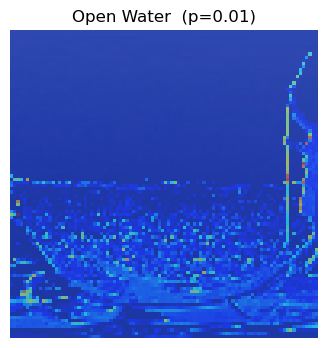

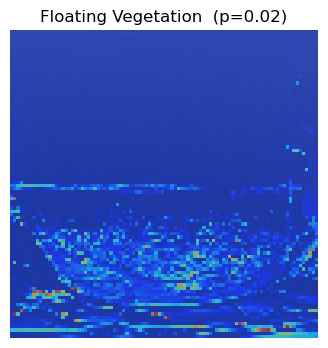

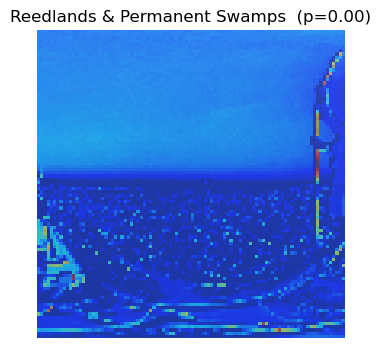

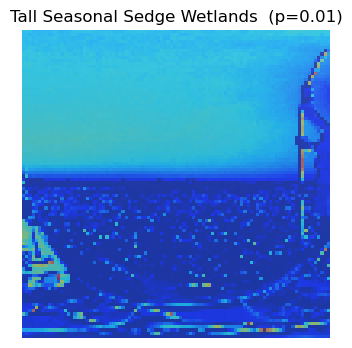

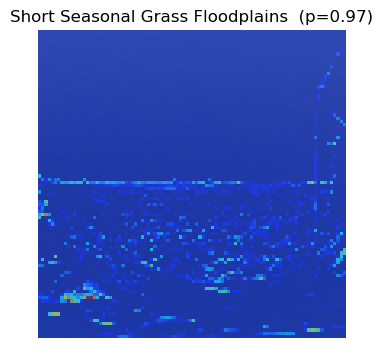

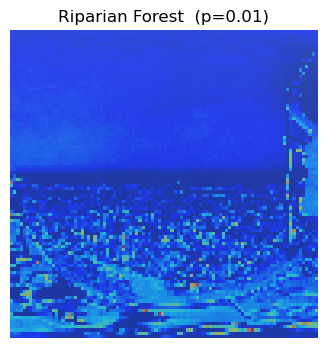

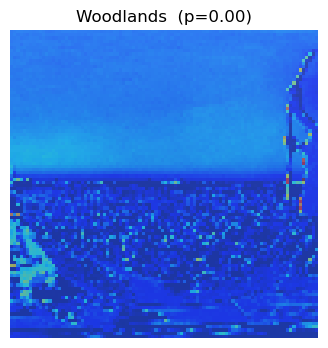

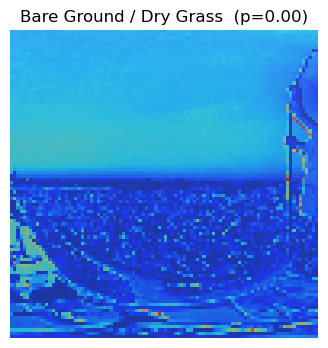

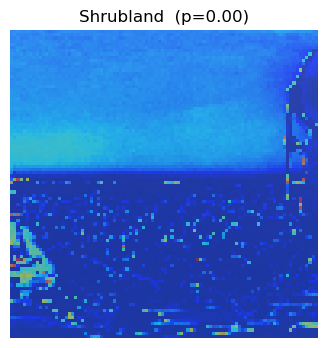

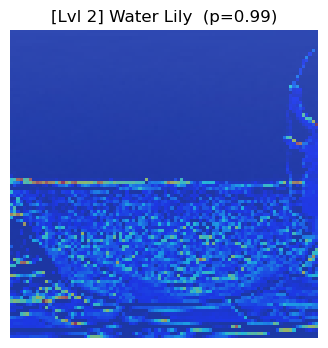

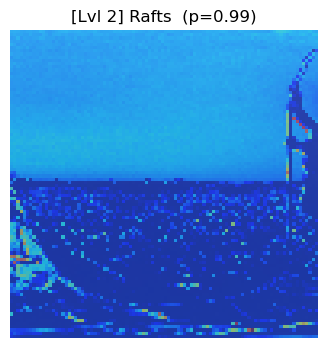

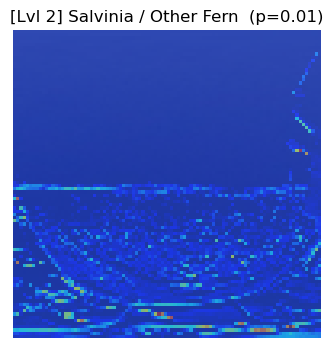

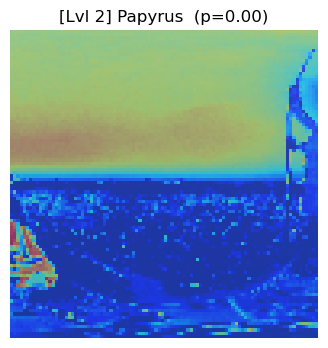

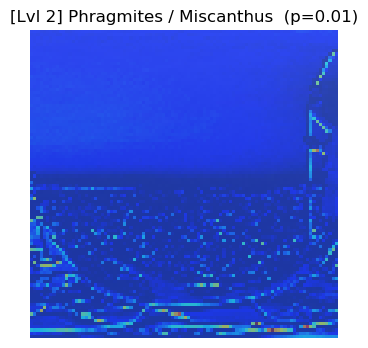

In [ ]:
# Prepare GradCAM SwinV2-base last stage lives at model.model.layers[-1]
target_layer  = model.model.patch_embed.proj  
cam_extractor = GradCAM(model, target_layer=target_layer)

# Load a test image
IMG_WIDTH = classifier.transform.transforms[0].size[0]  
mean, std = classifier.transform.transforms[2].mean, classifier.transform.transforms[2].std

image_path = "ALL_SPLIT_IMAGES/IMG_20230801_105724_00_820_right.jpg"
orig = Image.open(image_path).convert("RGB")

# build the 1×3×W×W tensor 
inp = classifier.transform(orig).unsqueeze(0).to(device)

# Forward pass once (no torch.no_grad— we need grads)
out = model(inp) # [1, C]
C = out.shape[1]

for cls in range(C):
    # tell GradCAM to use the same forward graph again
    cams = cam_extractor(cls, scores=out, retain_graph=True)  
    cam = cams[0][0].cpu().detach().numpy()

    # normalize to [0,1]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    plt.figure(figsize=(4,4))
    plt.imshow(orig.resize((IMG_WIDTH,IMG_WIDTH)))
    plt.imshow(cam, cmap="jet", alpha=0.5)
    lbl  = classifier.label_columns[cls]
    prob = torch.sigmoid(out)[0, cls].item()
    plt.title(f"{lbl}  (p={prob:.2f})")
    plt.axis("off")
    plt.show()


## 4. Deploying Classifier Across All Images

In [7]:
IMG_FOLDER = "ALL_SPLIT_IMAGES"
classifier, mean, std, img_width = Classifier.load("best_model.pt", "best_classifier.json")
labels = classifier.label_columns

def classify_images(excelfile):
    df = pd.read_excel(excelfile)
    out_rows = []

    for _, row in df.iterrows():
        base = Path(row["Image"]).stem
        for side in ("left", "right"):
            img_filename = f"{base}_{side}.jpg"
            img_path = Path(IMG_FOLDER) / img_filename

            # predict if exists, else all zeros
            if img_path.exists():
                img = Image.open(img_path).convert("RGB")
                preds = classifier.predict_binary(img)
            else:
                preds = np.zeros(len(labels), dtype=int)

            # start with all original fields
            new_row = row.to_dict()
            # then insert Image_side, side, then each class
            new_row["Image_side"] = img_filename
            new_row["side"]       = side
            for lbl, p in zip(labels, preds):
                new_row[lbl] = int(p)

            out_rows.append(new_row)

    out_df = pd.DataFrame(out_rows)

    out_file = Path(excelfile).with_name(Path(excelfile).stem + "_classifications.xlsx")
    out_df.to_excel(out_file, index=False)
    print(f"Saved expanded sheet to {out_file}")

In [8]:
# classify_images("08_OP_23.xlsx")


In [9]:
# classify_images("09_OKE_23.xlsx")
# classify_images("10_OKW_23.xlsx")